In [1]:
import os
import time
from math import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import graphviz


t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 46)

In [3]:
columns_quant = ['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']

columns_cat = ['display_env',
            'target_env',
            'campaignscenario',
            'campaignvertical',
            'is_interstitial',
            'device_type']

X_quant = df[columns_quant]
X_quant_scaled = StandardScaler().fit_transform(X_quant)
print(len(X_quant.columns))
display(X_quant.columns)

X_cat = df[columns_cat]
X_cat = pd.get_dummies(X_cat, columns=columns_cat, drop_first=True)
X_cat_scaled = StandardScaler().fit_transform(X_cat)
print(len(X_cat.columns))
display(X_cat.columns)

X_quant_cat = df[columns_quant + columns_cat]
X_quant_cat = pd.get_dummies(X_quant_cat, columns=columns_cat, drop_first=True)
X_quant_cat_scaled = StandardScaler().fit_transform(X_quant_cat)
print(len(X_quant_cat.columns))
display(X_quant_cat.columns)

y = df['is_display_clicked']

13


Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')

21


Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone'],
      dtype='object')

34


Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro', 'display_env_app_ios', 'display_env_other',
       'display_env_web', 'target_env_2', 'campaignscenario_5',
       'campaignscenario_6', 'campaignscenario_11', 'campaignscenario_12',
       'campaignscenario_13', 'campaignscenario_17', 'campaignvertical_20.0',
       'campaignvertical_23.0', 'campaignvertical_129.0',
       'campaignvertical_200002.0', 'is_interstitial_True',
       'device_type_Desktop', 'device_type_Desktop - Safari',
       'device_type_Mobile - Other', 'device_type_Unknown', 'device_type_iPad',
       'device_type_iPhone'],
      dtype='object')

In [4]:
class Modelisation():
    def __init__(self, X, y, model, scaling=True):
        self.X_columns = X.columns
        
        if scaling:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        probs = model.predict_proba(X_test)[:, 1]
        
        TP = cm[1][1]
        FN = cm[1][0]
        FP = cm[0][1]
        TN = cm[0][0]
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        # Recall
        Recall = TP/(TP+FN)
        # Precision
        Precision = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # F1_Score
        F1 = (2*Precision*Recall)/(Precision+Recall)

        metrics_score = {'f1': F1, 'recall': Recall,'negative predictive value': NPV,'precision': Precision, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
        self.recall = Recall
        

    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()     
    
    def show_metrics_score(self):
        for key, value in self.metrics_score.items():
            print(f"{key} : {value:.4f}")
            
    def show_ROC(self):
        fpr, tpr, _ = metrics.roc_curve(self.y_test, self.probs)
        plt.plot(fpr, tpr, label=f"{self.model}")
        plt.plot([0, 1], [0, 1], "r-", label='Modèle aléatoire')
        plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Modèle parfait')
        plt.legend()
        plt.title('Courbe ROC')
        plt.show()
    
    def show_attributes(self):
        # help(sklearn.tree._tree.Tree)
        tree = self.model.tree_
        attributes = {'max_depth': tree.max_depth, 'n_leaves': tree.n_leaves, 'node_count': tree.node_count}
        for key, value in attributes.items():
            print(f"{key} : {value}")
            
    def plot_tree(self):
        dot_data = tree.export_graphviz(self.model, out_file=None, 
                     feature_names=self.X_columns,  
                     class_names=['False', 'True'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
        graph = graphviz.Source(dot_data)  
        display(graph)

In [5]:
import sklearn
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

# Decision tree

## Variables quantitatives

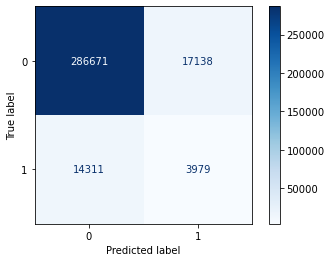

f1 : 0.2019
recall : 0.2176
negative predictive value : 0.9525
precision : 0.1884
roc_auc : 0.5806


In [6]:
m = Modelisation(X_quant, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

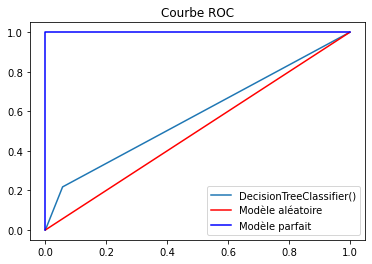

In [7]:
m.show_ROC()

In [8]:
m.show_attributes()

max_depth : 55
n_leaves : 92294
node_count : 184587


<ipython-input-4-f103a0e64527>:26: RuntimeWarning: invalid value encountered in longlong_scalars
  Precision = TP/(TP+FP)


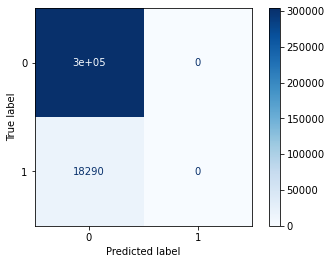

f1 : nan
recall : 0.0000
negative predictive value : 0.9432
precision : nan
roc_auc : 0.7388


In [9]:
m = Modelisation(X_quant, y, DecisionTreeClassifier(max_depth=2))
m.show_conf_matrix()
m.show_metrics_score()

In [10]:
m.show_attributes()

max_depth : 2
n_leaves : 4
node_count : 7


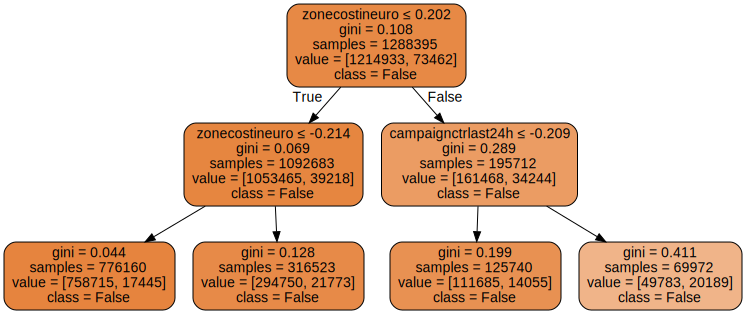

In [11]:
m.plot_tree()

## Categorical variables

In [12]:
# Nombre de valeurs distinctes
for column in columns_cat:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7


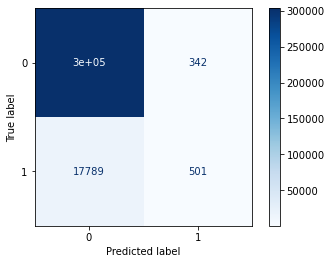

f1 : 0.0524
recall : 0.0274
negative predictive value : 0.9446
precision : 0.5943
roc_auc : 0.6918


In [13]:
m = Modelisation(X_cat, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [14]:
m.show_attributes()

max_depth : 19
n_leaves : 339
node_count : 677


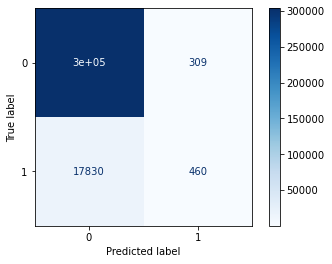

f1 : 0.0483
recall : 0.0252
negative predictive value : 0.9445
precision : 0.5982
roc_auc : 0.6730


In [15]:
m = Modelisation(X_cat, y, DecisionTreeClassifier(max_depth=5))
m.show_conf_matrix()
m.show_metrics_score()

In [16]:
m.show_attributes()

max_depth : 5
n_leaves : 28
node_count : 55


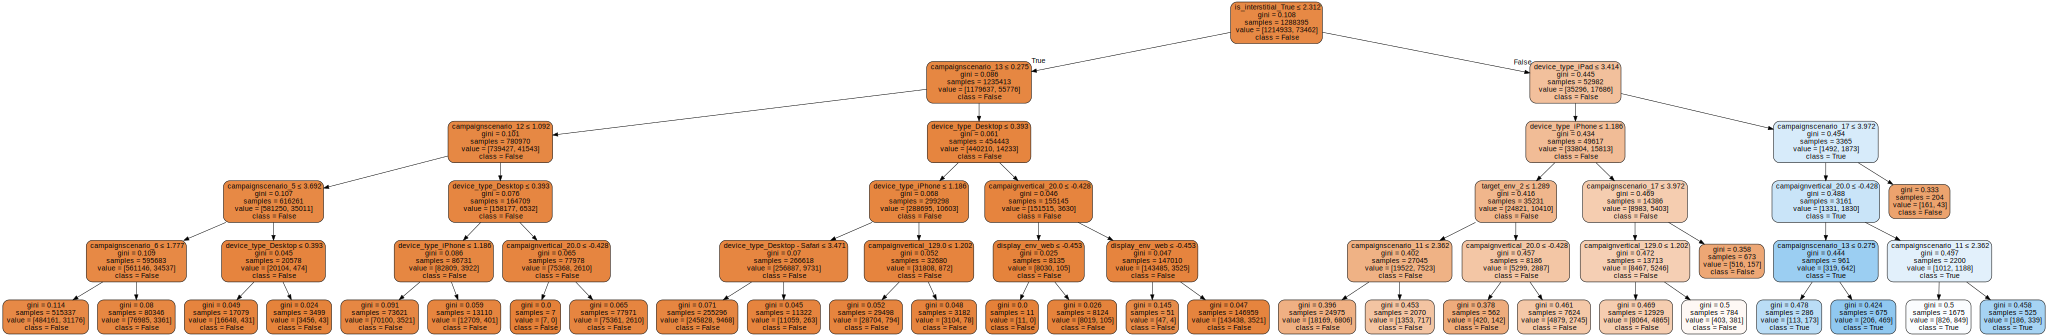

In [17]:
m.plot_tree()

## Quantitative + categorical

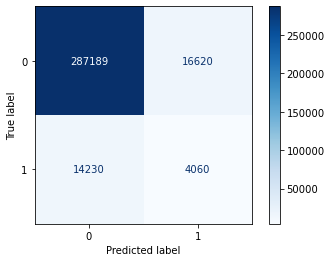

f1 : 0.2084
recall : 0.2220
negative predictive value : 0.9528
precision : 0.1963
roc_auc : 0.5836
Wall time: 29.6 s


In [18]:
%%time
m = Modelisation(X_quant_cat, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [19]:
m.show_attributes()

max_depth : 52
n_leaves : 90241
node_count : 180481


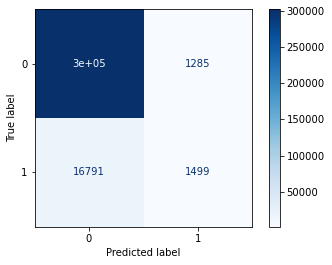

f1 : 0.1423
recall : 0.0820
negative predictive value : 0.9474
precision : 0.5384
roc_auc : 0.7828


In [20]:
m = Modelisation(X_quant_cat, y, DecisionTreeClassifier(max_depth=4))
m.show_conf_matrix()
m.show_metrics_score()

In [21]:
m.show_attributes()

max_depth : 4
n_leaves : 16
node_count : 31


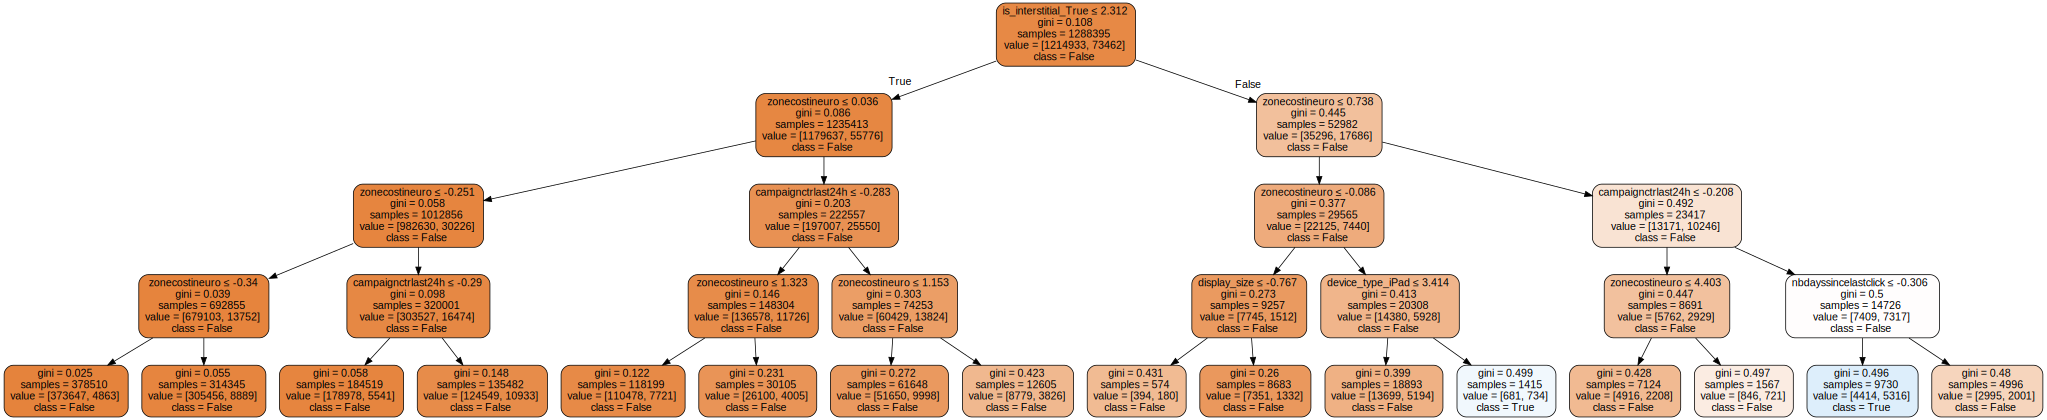

In [22]:
m.plot_tree()

# Random Forest

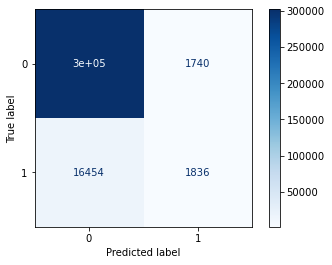

f1 : 0.1679
recall : 0.1004
negative predictive value : 0.9483
precision : 0.5134
roc_auc : 0.7382
Wall time: 18.5 s


In [23]:
%%time
m = Modelisation(X_quant_cat, y, RandomForestClassifier(n_estimators=10, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

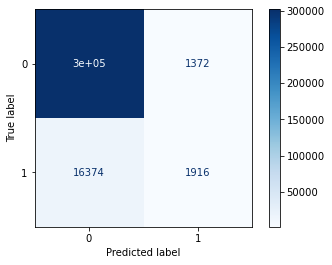

f1 : 0.1776
recall : 0.1048
negative predictive value : 0.9486
precision : 0.5827
roc_auc : 0.8144
Wall time: 2min 24s


In [24]:
%%time
m = Modelisation(X_quant_cat, y, RandomForestClassifier(n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

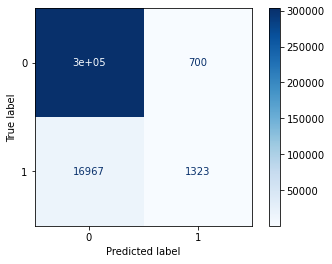

f1 : 0.1303
recall : 0.0723
negative predictive value : 0.9470
precision : 0.6540
roc_auc : 0.8351
Wall time: 2min 5s


In [25]:
%%time
m = Modelisation(X_quant_cat, y, RandomForestClassifier(min_samples_leaf=15, n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

In [26]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:06:23
